In [2]:
import pandas as pd
import numpy as np
import openml as oml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import os

## Stabilność

In [3]:
def find_current_max(array):    
    max_auc = [array[0]]
    for i in range(1, len(array)):
        max_auc.append(np.fmax(max_auc[-1], array[i]))
    return max_auc
    
    
def current_auc_plot_ax(model, dataset_id, ax, dataset_labels, i, map_models):
    results_dir = '../scripts/results/'
    rs = pd.read_csv(results_dir + model +'_random_search_results.csv')
    bo = pd.read_csv(results_dir + model +'_bayes_search_results.csv')
    rs_auc = np.array(rs.loc[rs['dataset_id'] == dataset_id,'mean_test_score'])
    bo_auc = np.array(bo.loc[bo['dataset_id'] == dataset_id,'mean_test_score'])
    if i == 0:
        ax.plot(find_current_max(rs_auc), label='Random Search', color='#994F00')
        ax.plot(find_current_max(bo_auc), label='Bayes Optimization', color = '#006CD1')
    else:
        ax.plot(find_current_max(rs_auc),  color='#994F00')
        ax.plot(find_current_max(bo_auc), color = '#006CD1')
    if i < 4:
        ax.set_title(dataset_labels[dataset_id], fontsize=11)
    if i >= 8:    
        ax.set_xlabel('No. of iteration')
    if i % 4 == 0:    
        ax.set_ylabel('ROC AUC')
    if i % 4 ==3:   
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(map_models[model], color='black')
    
    

In [4]:
plt.style.use('ggplot')
models = ['RF', 'ENET', 'DT']
model_names = ['Random forest', 'Elastic Net', 'Decision Tree']
data_ids = [37 ,1464, 1489, 40983]
dataset_labels = {
    37: 'diabetes',
    1464: 'blood-transfusion-service-center',
    1489: 'phoneme',
    40983: 'wilt'
}
model_names = ['Random forest', 'Elastic Net', 'Decision Tree']
map_models = dict(zip(models, model_names))

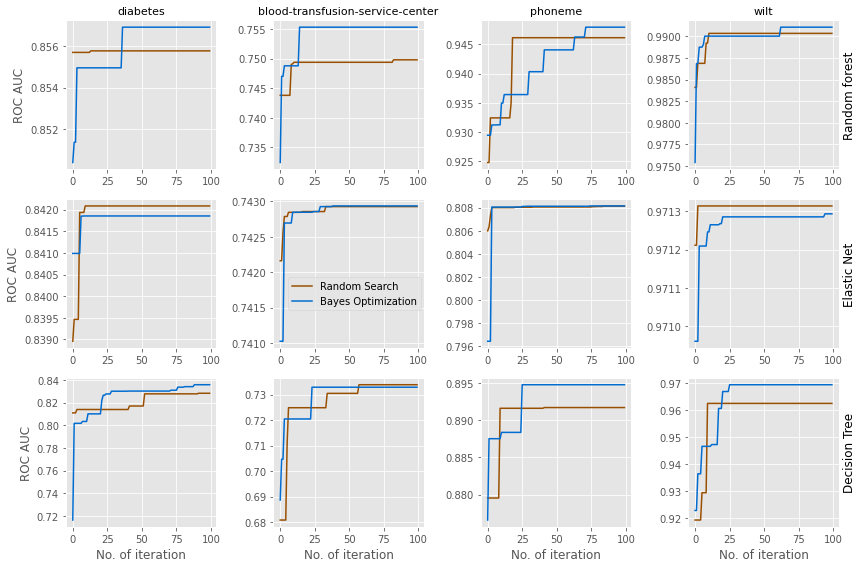

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))


axes = axes.flatten()

# # Create 12 plots
i=0
for model in models:
    for dataset_id in data_ids:
        current_auc_plot_ax(model, dataset_id, axes[i], dataset_labels, i, map_models)
        i+=1

plt.style.use('ggplot')
plt.tight_layout()
fig.legend(bbox_to_anchor=(0.49, 0.02, 0, 0.5))


plt.savefig('best_auc.png')

## Tunowalność

In [7]:
def tunability(model, data_ids, method):
    tun = []
    for dataset_id in data_ids:
        tun.extend(auc_per_dataset(model, dataset_id, method))
    return tun

def auc_per_dataset(model, dataset_id, method):
    results_dir = '../scripts/results/'
    rs = pd.read_csv(results_dir + model +'_' + 'random' +'_search_results.csv')
    rs = rs.loc[rs['dataset_id'] == dataset_id,:]
    #NaN w elastic net
    rs = rs.loc[rs['mean_test_score'].notna(),:]
    #optimal default
    val_for_def = rs.loc[rs['dataset_id'] == dataset_id,:].sort_values(by='total_mean_auc', 
                                                                       ascending = False).head(1)['mean_test_score']
   
    if method == 'random':
        scores = rs['mean_test_score']
    elif method=='bayes':
        bs = pd.read_csv(results_dir + model +'_' + method +'_search_results.csv')
        bs = bs.loc[bs['dataset_id'] == dataset_id,:]
        #bs = bs.dropna()
        bs = bs.loc[bs['mean_test_score'].notna(),:]
        scores = bs['mean_test_score']
    
    return np.max(val_for_def) - scores

In [9]:
def plot_tunability_per_set(method):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    axes = axes.flatten()

    for i in range(len(models)):
        ax = axes[i]
        data = [-np.min(auc_per_dataset(models[i], dataset_id, method) ) for dataset_id in data_ids]

        ax.bar([str(id) for id in data_ids], data)#positions=[1, 2, 3, 4], labels=data_ids)

        ax.set_ylim(0, 0.033)
        ax.set_xlabel('Dataset id')
        if i==0:
            ax.set_ylabel('ROC AUC tunability')
        ax.set_title(model_names[i])

    plt.tight_layout()
    plt.savefig('auc_per_dataset_' + method)

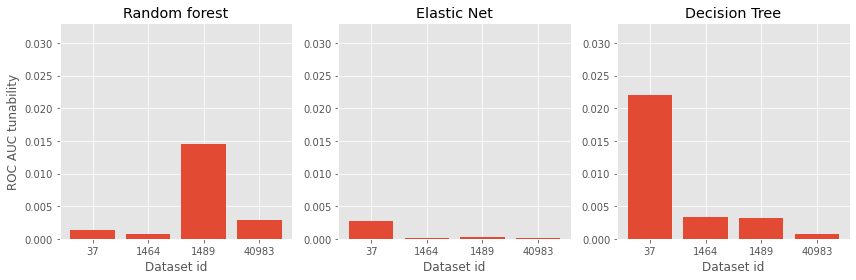

In [10]:
plot_tunability_per_set('random')

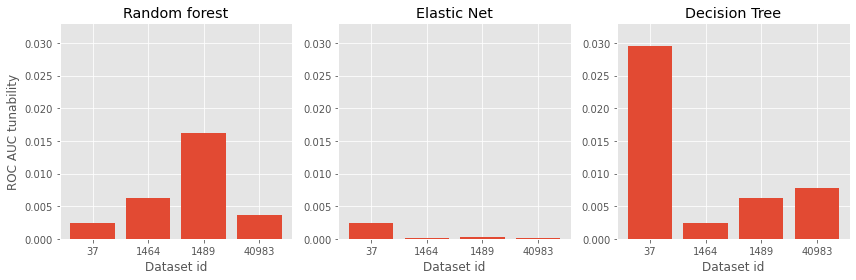

In [11]:
plot_tunability_per_set('bayes')

In [12]:
def plot_tunability_mean(method):
    tuns = []
    for i in range(len(models)):

        data = [-np.min(auc_per_dataset(models[i], dataset_id, method) ) for dataset_id in data_ids]
        tuns.append(np.mean(data))

    plt.bar(model_names, tuns)
    plt.tight_layout()
    plt.ylim(0, 0.012)
    plt.savefig('tunability_' + method +'6')

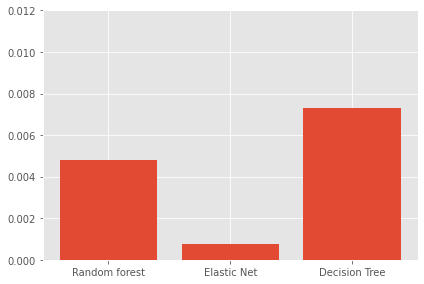

In [13]:
plot_tunability_mean('random')

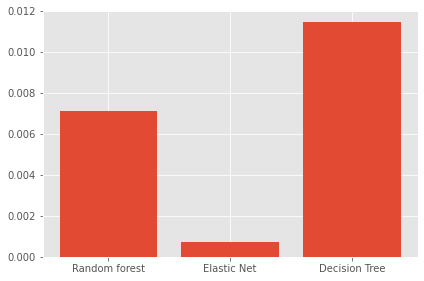

In [14]:
plot_tunability_mean('bayes')